# Image processing

## Image dilation

Image dilation and erosion form the basic operations of morphological image processing:

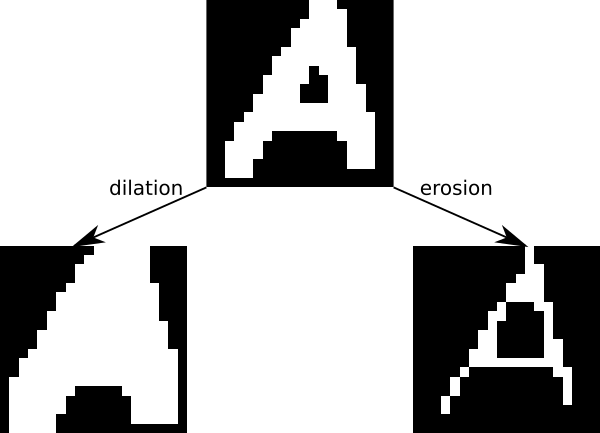

Dilation of binary images can be understood as processing the binary image using a mask in the following manner:

1. The mask is positioned with its reference-point (usually the mask center) at each pixel position of the image.
2. For each position, we check, whether pixels within the mask overlap with the set of foreground pixels of the binary image.
3. If this is the case, then the respective pixel is set 1: it is part of the dilated image. If not, it is set 0.

Since we perform the identical operation for each pixel, this operation can run in parallel for each pixel on GPU.

### Context

Together with image erosion we can perform a closing-operation, which is a common operation in image segmentation tasks to remove artifacts (e.g. holes) in thresholded images:

|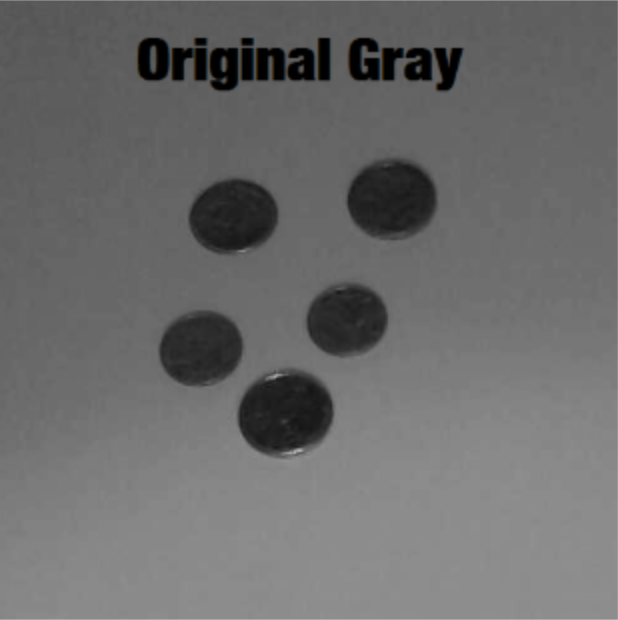| 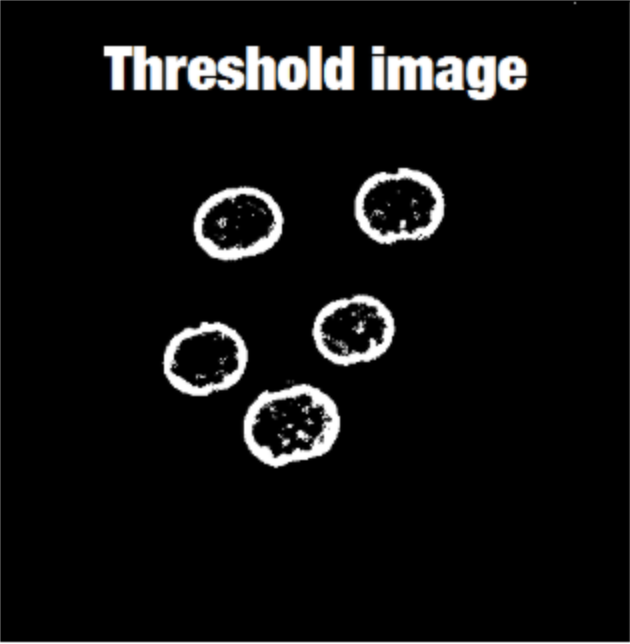 | 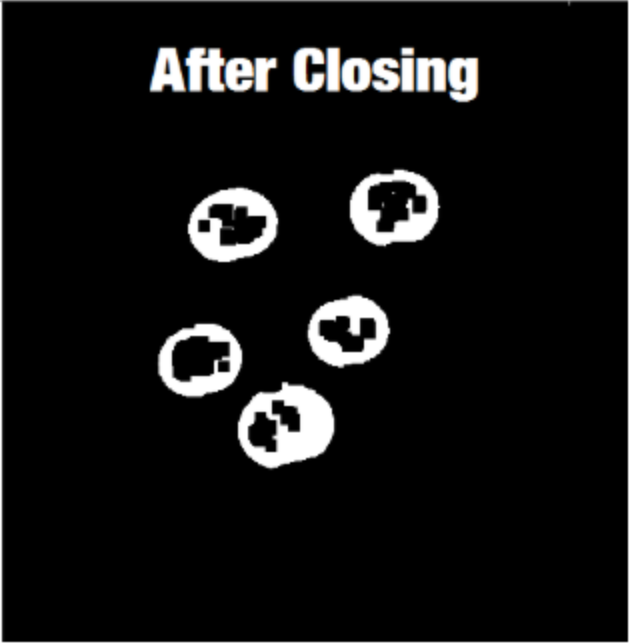 |

### Implementation

Implementation of image dilation:

* In the following we assume that the mask is composed of a centered 3x3 pixel area.
* Dilation can then be implemented as two for-loops running over the neighborhood of each pixel.
* In the loops, we determine tha maximum value in that neighborhood and set the repective pixel to that value.

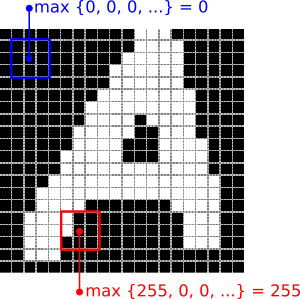


 Image credits: [1](https://towardsdatascience.com/get-started-with-gpu-image-processing-15e34b787480), [2](https://blog.christianperone.com/2014/06/simple-and-effective-coin-segmentation-using-python-and-opencv/)


In [2]:
# kernel definition
def dilate_cpu(image, result):
    image_height, image_width = image.shape

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if 0 < row < image_height - 1:
        if 0 < col < image_width - 1:
            extreme_value = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    pixel_value = image[row + i, col + j]
                    extreme_value = max(pixel_value, extreme_value)
            result[row, col] = extreme_value

In [1]:
from numba import cuda

# kernel definition
@cuda.jit
def dilate_gpu(image, result):
    image_height, image_width = image.shape

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if 0 < row < image_height - 1:
        if 0 < col < image_width - 1:
            extreme_value = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    pixel_value = image[row + i, col + j]
                    extreme_value = max(pixel_value, extreme_value)
            result[row, col] = extreme_value

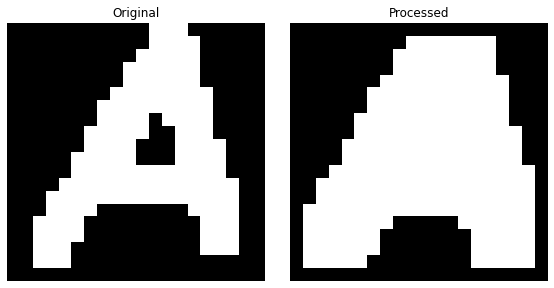

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

image = io.imread("../codes/image_processing/image_dilation/letter_image.png")
image_shape = image.shape[0]

image_dilated = np.zeros_like(image)

threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# call dilation kernel
dilate_gpu[blocks_per_grid, threads_per_block](image, image_dilated)


# keep only valid range
# image_dilated = image_dilated[1:-1, 1:-1]

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(image_dilated, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()
